<a href="https://colab.research.google.com/github/vitor-manoel-s/Desafio-DIO-recomendacao-por-imagem/blob/main/recomendacao_por_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import os
import tensorflow
import cv2 as cv
import numpy as np
import pickle
from google.colab.patches import cv2_imshow
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import GlobalMaxPooling2D
from numpy.linalg import norm
from sklearn.neighbors import NearestNeighbors

In [2]:
model = ResNet50(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
model.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Modificando o modelo

In [3]:
# adicionando GlobalMaxPooling:
model=tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Importando dataset

In [4]:
!kaggle datasets download -d sunnykusawa/ecommerce-products-image-dataset
!unzip ecommerce-products-image-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/sunnykusawa/ecommerce-products-image-dataset
License(s): CC0-1.0
 79% 32.0M/40.4M [00:00<00:00, 126MB/s] 
100% 40.4M/40.4M [00:00<00:00, 116MB/s]
Archive:  ecommerce-products-image-dataset.zip
  inflating: ecommerce products/jeans/1.jpg  
  inflating: ecommerce products/jeans/10.jpg  
  inflating: ecommerce products/jeans/100.jpg  
  inflating: ecommerce products/jeans/101.jpg  
  inflating: ecommerce products/jeans/102.jpg  
  inflating: ecommerce products/jeans/103.jpg  
  inflating: ecommerce products/jeans/104.jpg  
  inflating: ecommerce products/jeans/105.jpg  
  inflating: ecommerce products/jeans/106.jpg  
  inflating: ecommerce products/jeans/107.jpg  
  inflating: ecommerce products/jeans/108.jpg  
  inflating: ecommerce products/jeans/109.jpg  
  inflating: ecommerce products/jeans/11.jpg  
  inflating: ecommerce products/jeans/110.jpg  
  inflating: ecommerce products/jeans/111.jpg  
  inflating: ecommerce products/jeans/112.jpg 

In [10]:
base_dir = "/content/ecommerce products"

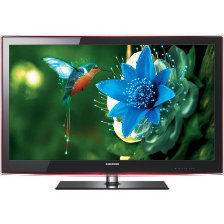

In [19]:
image = cv.imread("/content/ecommerce products/tv/1.jpg")
image = cv.resize(image, (224,224))
cv2_imshow(image)


In [20]:
image = np.array(image)
image.shape

(224, 224, 3)

In [22]:
# (number_of_images, 224, 224, 3)
expand_image = np.expand_dims(image, axis=0)
expand_image.shape

(1, 224, 224, 3)

In [24]:
preprocess_image = preprocess_input(expand_image)

In [25]:
preprocess_image

array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,


In [29]:
result = model.predict(preprocess_image).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


In [35]:
normalized = result/norm(result)

In [40]:
normalized

array([0.0416781 , 0.00689301, 0.04391032, ..., 0.00107772, 0.02189126,
       0.00928812], dtype=float32)

In [110]:
# Função de extração de features
def extract_features(img_path, model):
  image = cv.imread(img_path)
  if image is None:
    print(f"Error: Could not load image at path: {img_path}")
    return None

  image = cv.resize(image, (224,224))
  image = np.array(image)
  expand_image = np.expand_dims(image, axis=0)
  preprocess_image = preprocess_input(expand_image)
  result = model.predict(preprocess_image).flatten()
  normalized_result = result/norm(result)
  return normalized_result

In [52]:
extract_features('/content/ecommerce products/tv/1.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


array([0.0416781 , 0.00689301, 0.04391032, ..., 0.00107772, 0.02189126,
       0.00928812], dtype=float32)

In [53]:
filenames = []
feature_list = []

In [54]:
# Armazena os caminhos das imagens em filenames
for folder in os.listdir(base_dir):
  for file in os.listdir(os.path.join(base_dir, folder)):
    os.path.join(base_dir, folder, file)
    filenames.append(os.path.join(base_dir, folder, file))

In [55]:
# Extrai features para cada imagem usando a função extract_features
# Armazena as features em feature_list
for file in filenames:
  features = extract_features(file, model)
  if features is not None:  # Verifica se as features foram extraídos com sucesso
    feature_list.append(features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Usando Nearest Neighbors para encontrar imagens semelhantes com base na distância euclidiana entre seus vetores de características


In [105]:
neieighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neieighbors.fit(feature_list)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [106]:
image_path = '/content/ecommerce products/tv/155.jpg'

distances, indices = neieighbors.kneighbors([extract_features(image_path,model)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


------------------------------------ Imagem Original ------------------------------------



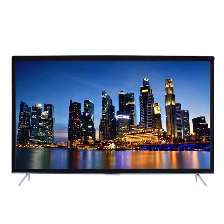

------------------------------------ Imagens Recomendadas ------------------------------------



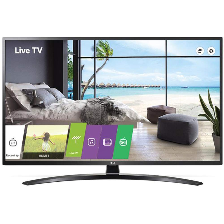

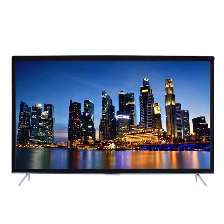

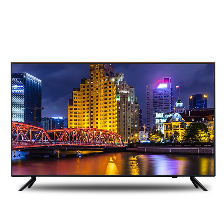

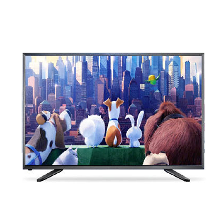

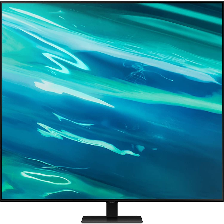

In [111]:
print("------------------------------------ Imagem Original ------------------------------------\n")

img_original = cv.imread(image_path)
img_original = cv.resize(img_original, (224,224))
cv2_imshow(img_original)


print("------------------------------------ Imagens Recomendadas ------------------------------------\n")

for file in indices[0][0:5]:
  img_recommended = cv.imread(filenames[file])
  img_recommended = cv.resize(img_recommended, (224,224))
  cv2_imshow(img_recommended)